In [1]:
# from sklearn.manifold import MDS
# import pandas as pd

# # data = load.readPd('dataset/gauss_data.txt')
# dis = load.disM_line('dataset/example_distances.txt')
# mds = MDS(n_components=2, dissimilarity='precomputed')
# data = mds.fit_transform(dis)
# data = pd.DataFrame(data, columns=['x', 'y'])


In [2]:
from load import *

load = load_xy('dataset/xy/')


600
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
          x       y  clusterID
161   8.164  10.534          5
182   8.270  10.716          5
468   4.316  12.764         12
44   12.340   9.918          2
367  13.986  14.770         10


<AxesSubplot:xlabel='x', ylabel='y'>

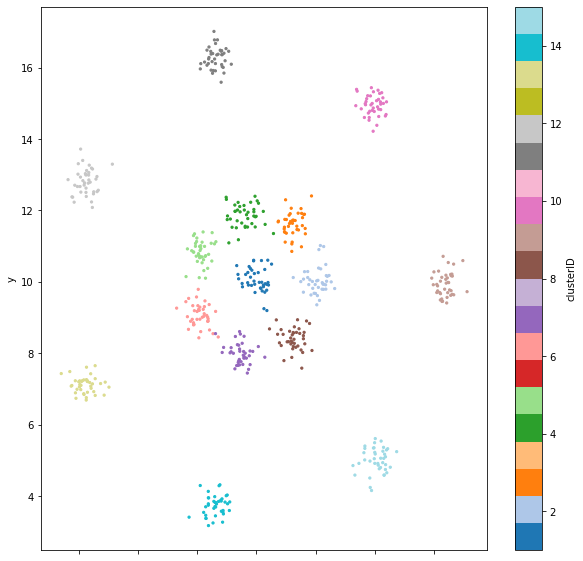

In [3]:
data = next(load)
data = next(load)
data = next(load)
print(len(data))
print(data['clusterID'].unique())
print(data.sample(5))
data.plot.scatter(x='x', y='y', c='clusterID', colormap='tab20', s=5, figsize=(10, 10))


In [4]:
from DPC import DPC

dpc = DPC(data[['x', 'y']])
dpc.calDis()
print(dpc.dis.max())

13.943265184310308


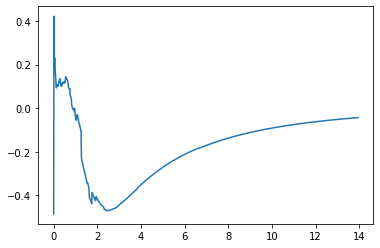

In [7]:
import matplotlib.pyplot as plt
plt.plot(dcs,bfs)

In [8]:
max(bfs)

0.42214399359159327

In [5]:
dcs,bfs=dpc.calDc(method='Bonferroni')

dc0.001
Bonferroni-0.48536717884691466
dc0.014956221405716025
Bonferroni0.42214399359159327
dc0.02891244281143205
Bonferroni0.19090083944443856
dc0.04286866421714808
Bonferroni0.23358585661536474
dc0.0568248856228641
Bonferroni0.22108052518007065
dc0.07078110702858012
Bonferroni0.17002801899764028
dc0.08473732843429616
Bonferroni0.15688442900154134
dc0.09869354984001218
Bonferroni0.12975710642032445
dc0.1126497712457282
Bonferroni0.10570420536558807
dc0.12660599265144423
Bonferroni0.09322719998639725
dc0.14056221405716024
Bonferroni0.10704614541518014
dc0.15451843546287627
Bonferroni0.10450571295534901
dc0.1684746568685923
Bonferroni0.10144732084861517
dc0.18243087827430832
Bonferroni0.10230106556055511
dc0.19638709968002435
Bonferroni0.10750348460457386
dc0.21034332108574036
Bonferroni0.10106195611650585
dc0.2242995424914564
Bonferroni0.11495879496650416
dc0.23825576389717243
Bonferroni0.12024735829036821
dc0.25221198530288846
Bonferroni0.12159237105167174
dc0.26616820670860447
Bonfer

In [6]:
bfs

NameError: name 'bfs' is not defined

In [ ]:
dpc.calRho()
dpc.calDel()
dpc.calGam()

dpc.getCen(15)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300, constrained_layout=True)
dpc.df.plot.scatter(x="x", y='y', c='rho', cmap='viridis', s=1, ax=ax[0])
dpc.df.plot.scatter(x="rho", y='delta', c='blue', s=1, ax=ax[1])

for i in dpc.centers:
    ax[0].scatter(dpc.df.loc[i, 'x'], dpc.df.loc[i, 'y'], c='red',s=1)
    ax[1].scatter(dpc.df.loc[i, 'rho'], dpc.df.loc[i, 'delta'], c='red',s=1)

# i = 2336
# ax[0].scatter(data.loc[i, 'x'], data.loc[i, 'y'], c='r', s=2)

ax[0].set_axis_off()
ax[0].set(title='distribution of density')
ax[1].set(title='decision graph', xlabel=r'$\rho$', ylabel=r'$\delta$')


<AxesSubplot:ylabel='Frequency'>

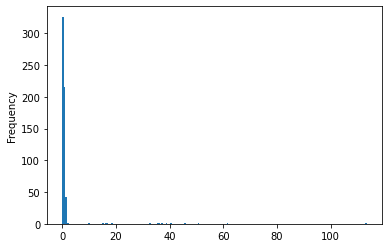

In [6]:
dpc.df['gamma'].plot.hist(bins=200)

In [7]:
import matplotlib.pyplot as plt
dpc.cluster()

print(np.sort(dpc.df['clusterID'].unique()))



0 178
1 496
2 428
3 548
4 451
5 366
6 359
7 279
8 587
9 97
10 299
11 74
12 6
13 203
14 154
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


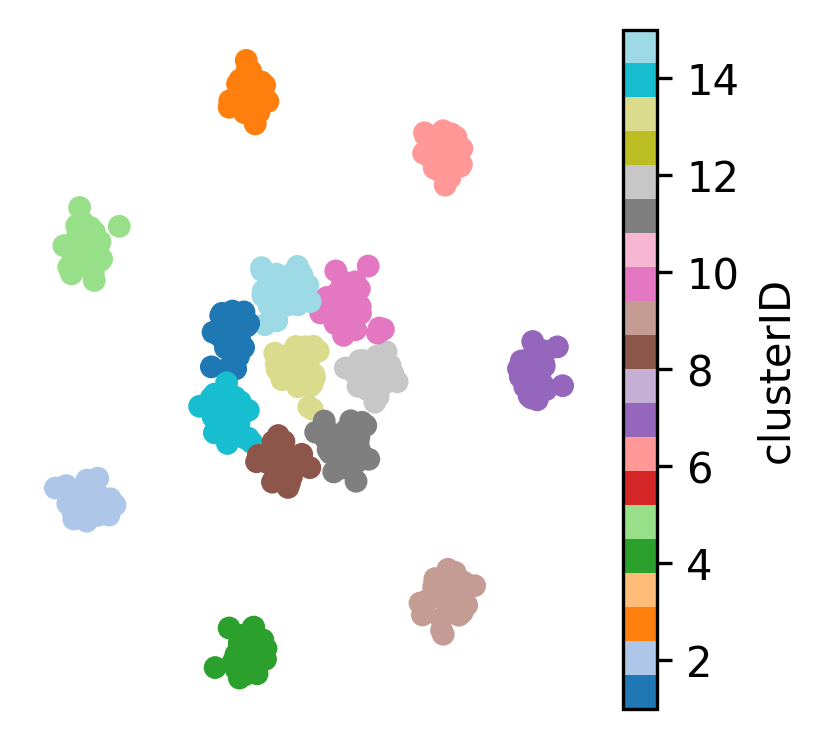

In [8]:

fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
for i, ri in dpc.df.drop(dpc.centers).iterrows():
    ax.arrow(ri['x'], ri['y'], dpc.df.loc[ri['toh'], 'x']-ri['x'], dpc.df.loc[ri['toh'], 'y']-ri['y'], lw=0.01, head_width=0.02)
# dpc.df.plot.scatter(x="x", y='y', s=1, c='rho', cmap='viridis', ax=ax)
# for i in [dpc.centers[7]]:
#     ax.scatter(dpc.df.loc[i,'x'],dpc.df.loc[i,'y'],c='r')

dpc.df.plot.scatter(x='x', y='y', c='clusterID', cmap='tab20', ax=ax)
ax.set_axis_off()
